# Data Centric XAI part - 2
## CHAPTER 03 - *Data Centric Approaches*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

This is part 2 of the tutorial part of Chapter 03 (Data Centric XAI). The part 1 can be viewed from the [part1 notebook](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter03/Data_Centric_XAI_part_1.ipynb). In this notebook, we will try to view the effect of adversarial attacks on inference data and certain ways to detect it.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn numba==0.53 adversarial-robustness-toolbox tensorflow sewar

### Loading the modules

In [109]:
import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniLInfMethod
from art.defences.preprocessor import SpatialSmoothing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sewar.full_ref import psnr, uqi, ergas
from IPython.display import Image, display

from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions


In this example, we are going to use a pre-trained ImageNet model from TensorFlow as we are simulating the situation of having a trained model and the inference data is exposed to adversarial attacks. We are going to make use of the [adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox) Python framework to generate the adversarial examples and use [sewar](https://sewar.readthedocs.io/en/latest/) a Python framework for image quality assessment. An image exposed to adversrial attack will have a degration in its quality or deviation in the statistical properties on the original image and hence we are going to detect adversarial example by using this framework. 

### Loading the data

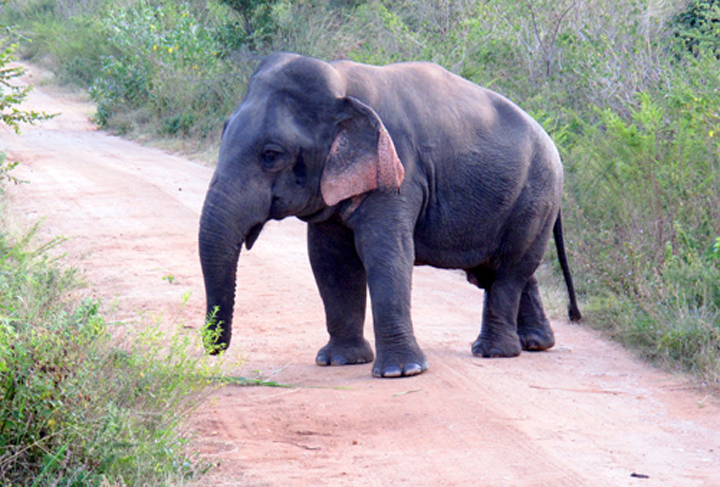

In [2]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "inference_data.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = 'https://i.imgur.com/JT7SP0M.jpeg')

In [3]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

### Defining the model

For this example, we are not training a model from scratch, but rather defining a pretrained Tensorflow Xception model to showcase the impact of Adversarial attacks in the inference data.

In [65]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]
    
pred_orig = get_model_predictions(normalized_img)

The predicted class is : Indian_elephant


### Generating Adevrsarial Examples using Adversarial-Robustness-Toolbox

In [27]:
art_model = KerasClassifier(model=model, clip_values=(0, 1))

#### Using FGSM

In [111]:
attack_fgsm = FastGradientMethod(art_model, eps = 0.1)
adv_images_fgsm = attack_fgsm.generate(x = normalized_img)
pred_fgsm = get_model_predictions(adv_images_fgsm)

The predicted class is : tusker


#### Using C&W method

In [69]:
attack_cw = CarliniLInfMethod(art_model, max_iter=100, verbose=True)
adv_images_cw = attack_cw.generate(x = normalized_img, verbose=True)
pred_cw =get_model_predictions(adv_images_cw)

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

The predicted class is : tusker


#### Using PGD

In [67]:
norm = 2
attack_pgd = ProjectedGradientDescent(art_model, eps = 0.1, verbose=True)
adv_images_pgd = attack_pgd.generate(x = normalized_img, verbose=True)
pred_pgd = get_model_predictions(adv_images_pgd)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

The predicted class is : maze


### Displaying the adversarial examples

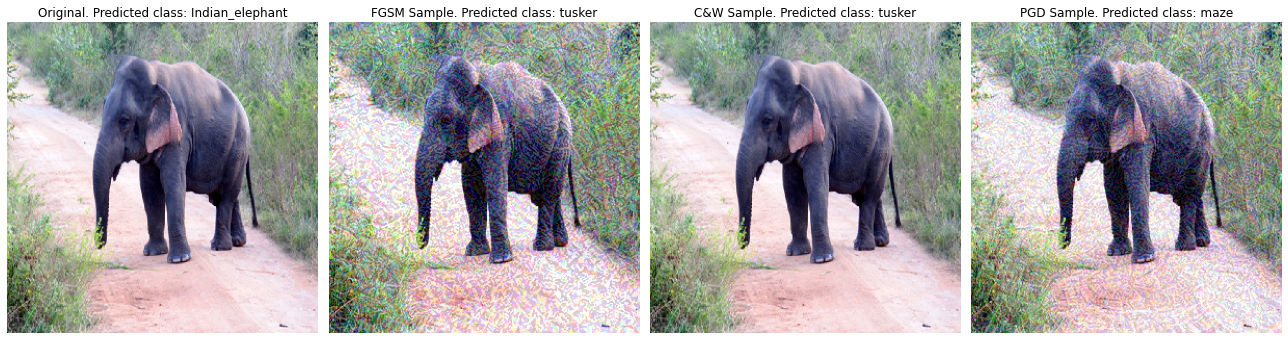

In [115]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,12))
ax1.imshow(normalized_img[0])
ax1.set_title(f'Original. Predicted class: {pred_orig}')
ax1.set_axis_off()
ax2.imshow(adv_images_fgsm[0])
ax2.set_title(f'FGSM Sample. Predicted class: {pred_fgsm}')
ax2.set_axis_off()
ax3.imshow(adv_images_cw[0])
ax3.set_title(f'C&W Sample. Predicted class: {pred_cw}')
ax3.set_axis_off()
ax4.imshow(adv_images_pgd[0])
ax4.set_title(f'PGD Sample. Predicted class: {pred_pgd}')
ax4.set_axis_off()
plt.tight_layout()

### Comparing the image quality of the adversarial examples with the original image

For comparing the image quality of the original sample with the adversarial examples, we will be making use of the Sewar package: https://pypi.org/project/sewar/ ad use the metrics PSNR, UQI and ERGAS to score the difference in image quality between the adversarial sample and the actual samples. More information on these metrics and other metrics can be found at: https://sewar.readthedocs.io/en/latest/.

In [108]:
# Calculate the image quality scores
image_quality_df = pd.DataFrame(columns = ['Sample', 'PSNR', 'ERGAS', 'UQI'])
# Original Sample
image_quality_dict = {'Sample' : 'Original', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (normalized_img*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (normalized_img[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], normalized_img[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# FGSM Sample
image_quality_dict = {'Sample' : 'FGSM', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_fgsm*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_fgsm[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_fgsm[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# C&W Sample
image_quality_dict = {'Sample' : 'C&W', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_cw*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_cw[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_cw[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# PGD
image_quality_dict = {'Sample' : 'PGD', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_pgd*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_pgd[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_pgd[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
display(image_quality_df)    

,Sample,PSNR,ERGAS,UQI
0,Original,inf,0.000000,1.000000
1,FGSM,158.762624,9038.356295,0.970892
2,C&W,184.680289,430.885103,0.999962
3,PGD,160.478128,7453.775587,0.979038


For this demonstration, we have used the adversarial attacks using the methods FGSM, C&W and PGD. Other forms of adversarial attacks provided by the Adversarial-Robustness-Toolbox can be viewed from the [official documentations](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html). We can observe that due to the adversarial attack, the original model prediction of *Indian Elephant* got changed to a *Tusker* and *Maze* which are incorrect. *Tusker* still seem to be okay although in the image, the elephant does not have any tusk! But the prediction of *Maze* was no where close. 

When we try to do a visual qualitative comparison, we see that FGSM generated sample has the highest amount of perturbation followed by PGD and C&W. The C&W generated samples look more realistic and it is hard to detect the adversarial sample even by human experts for C&W generated samples.


Now, when we compare the metric scores of the generated adversarial samples with the original data, we see that the metric ERGAS gives us a clear reading of the amount of Perturbations created and hence it is highest for the FPSM sample, followed by the PGD sample. But PSNR and UQI also gives us some indication about the perturbations created by the adversarial attacks.

### Suggestions to improve adversarial robustness

As discussed in the *Chapter 03* under section *Methods to increase Adversarial Robustness*, the most common approaches to increase Adversarial Robustness of models is by the following ways:

- Spatial Smoothing
- Adversarial Training
- Transfer Learning with Adversarial Examples

For the purpose of demonstration in this notebook, we are only going to see the usage of Spatial Smoothing to increase Adversarial Robustness of model.

In [123]:
# Defending using Spatial Smoothing of the samples
spatial_smoothing = SpatialSmoothing(window_size=9)
# FGSM
smooth_fgsm, _ = spatial_smoothing(adv_images_fgsm)
pred_fgsm_ss = get_model_predictions(smooth_fgsm)
# C&W
smooth_cw, _ = spatial_smoothing(adv_images_cw)
pred_cw_ss = get_model_predictions(smooth_cw)
# PGD
smooth_pgd, _ = spatial_smoothing(adv_images_pgd)
pred_pgd_ss = get_model_predictions(smooth_pgd)

The predicted class is : tusker
The predicted class is : tusker
The predicted class is : tusker


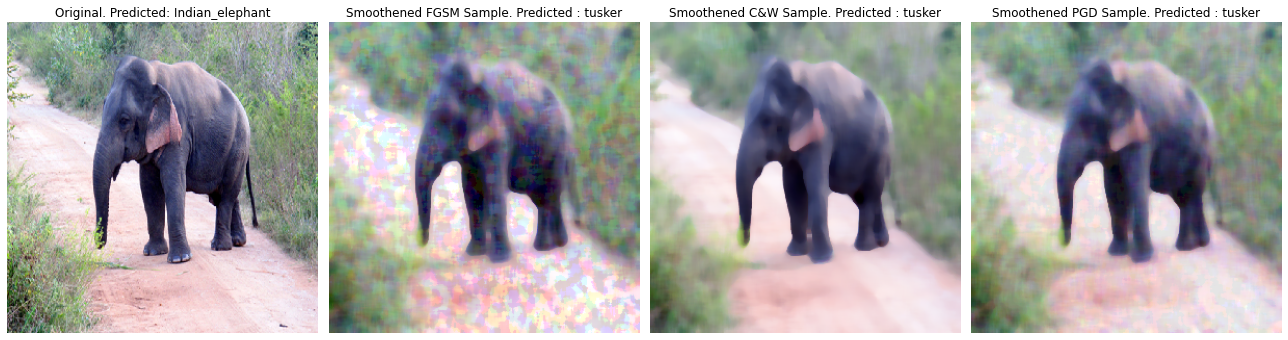

In [126]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,12))

#fig.suptitle('Adversarial samples with the original')
ax1.imshow(normalized_img[0])
ax1.set_title(f'Original. Predicted: {pred_orig}')
ax1.set_axis_off()
ax2.imshow(smooth_fgsm[0])
ax2.set_title(f'Smoothened FGSM Sample. Predicted : {pred_fgsm_ss}')
ax2.set_axis_off()
ax3.imshow(smooth_cw[0])
ax3.set_title(f'Smoothened C&W Sample. Predicted : {pred_cw_ss}')
ax3.set_axis_off()
ax4.imshow(smooth_pgd[0])
ax4.set_title(f'Smoothened PGD Sample. Predicted : {pred_pgd_ss}')
ax4.set_axis_off()
plt.tight_layout()

In [125]:
# Calculate the image quality scores
image_quality_df = pd.DataFrame(columns = ['Sample', 'PSNR', 'ERGAS', 'UQI'])
# Original Sample
image_quality_dict = {'Sample' : 'Original', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (normalized_img*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (normalized_img[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], normalized_img[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# FGSM Sample
image_quality_dict = {'Sample' : 'FGSM', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (smooth_fgsm*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (smooth_fgsm[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], smooth_fgsm[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# C&W Sample
image_quality_dict = {'Sample' : 'C&W', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (smooth_cw*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (smooth_cw[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], smooth_cw[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# PGD
image_quality_dict = {'Sample' : 'PGD', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (smooth_pgd*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (smooth_pgd[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], smooth_pgd[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
display(image_quality_df)    

,Sample,PSNR,ERGAS,UQI
0,Original,inf,0.000000,1.000000
1,FGSM,159.692848,7656.012607,0.972752
2,C&W,161.645406,5296.282700,0.986399
3,PGD,160.957635,6308.788189,0.981129


In this example, although Spatial Smoothing did not help much, but it did modify the sample attacked by the PGD method, that predicted the output as maze and instead the output is predicted as tusker, which is still close the category of elephants. Other approaches to increase the adversarial robustness such as Adversarial training which exposes adversarial samples using data augmentation is more effective but time consuming as the training is done from scratch. Similarly, transfer learning with Adversarial samples can also be effective in increasing adversarial robustness of models. But monitoring adversarial attacks is an important part of Data Centric XAI. 

### Final Thoughts

In this notebook, you have learnt how adversarial attacks can harm model outcome. You have also learnt how to generate Adversarial samples using various methods provided by the Adversarial-Robustness-Toolkit and how to evaluate or compare corrupt samples with the original data. Finally we have discussed about usage of Spatial Smoothing as a defense mechanism against Adversarial attacks. I would recommend everyone to try out other methods to increase adversarial robustness as suggested in *Chapter 03 - Data Centric Approaches* of the book **Applied Machine Learning Explainability Techniques** 

## Reference

1. Adversarial-Robustness-Toolbox - https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
2. Training on Adversarial Robustness - https://adversarial-ml-tutorial.org/
3. Sewar Framework Documention- https://sewar.readthedocs.io/en/latest/